In [1]:
import os
import csv
import cv2 
import numpy as np 
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Lambda, Flatten, Cropping2D

Using TensorFlow backend.


In [2]:
### loading data 
# read the data from csv files and split into the training/validation set
samples = []
# from the record with track 1 
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
        
# from the record with track 2
with open('./data2/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

train_samples, validation_samples = train_test_split(samples[0:], test_size = 0.2, random_state = 1) 

In [3]:
# size of the training/validation set
# (This is before the data augmentatin, Note also that each sample contains 
# three images corresponding to center, left and right cameras)
train_size = len(train_samples)
validation_size = len(validation_samples) 

# shape of the image is (160, 320, 3), each entry takes a value in [0, 255] (before normalization)
# (The stored file name is in thee form of "/Users/tatsuo/Desktop/data/IMG/....jpg" and thus
# "/Users/tatsuo/Desktop/" part should be removed and "./" should be added.)
name_sample_center = './' + train_samples[0][0][22:]
img_sample_center = cv2.imread(name_sample_center)
img_shape = img_sample_center.shape

In [4]:
# ### This part is for generating figures for the write-up
# # sample image (center, left, right cameras) as well as flipped center image 
# name_sample_center = './' + train_samples[0][0][22:]
# name_sample_left = './' + train_samples[0][1][22:]
# name_sample_right = './' + train_samples[0][2][22:]
# img_sample_center = cv2.imread(name_sample_center)
# img_sample_left = cv2.imread(name_sample_left)
# img_sample_right = cv2.imread(name_sample_right)

# img_sample_center_flipped = np.fliplr(img_sample_center)

# # plot and save the center image
# plt.imshow(cv2.cvtColor(img_sample_center, cv2.COLOR_BGR2RGB))
# plt.title('original image (center camera)')
# plt.savefig('center.png')
# plt.show()

# # plot and save the center image and the flipped one
# fig=plt.figure(figsize=(12, 3))
# fig.add_subplot(1,2,1)
# plt.imshow(cv2.cvtColor(img_sample_center, cv2.COLOR_BGR2RGB))
# plt.title('original image (center camera)')
# fig.add_subplot(1,2,2)
# plt.imshow(cv2.cvtColor(img_sample_center_flipped, cv2.COLOR_BGR2RGB))
# plt.title('flipped image (center camera)')
# plt.savefig('flipped.png')
# plt.show()

# # plot and save the center, left and right images
# fig=plt.figure(figsize=(18, 4))
# fig.add_subplot(1,3,1)
# plt.imshow(cv2.cvtColor(img_sample_left, cv2.COLOR_BGR2RGB))
# plt.title('original image (left camera)')
# fig.add_subplot(1,3,2)
# plt.imshow(cv2.cvtColor(img_sample_center, cv2.COLOR_BGR2RGB))
# plt.title('original image (center camera)')
# fig.add_subplot(1,3,3)
# plt.imshow(cv2.cvtColor(img_sample_right, cv2.COLOR_BGR2RGB))
# plt.title('original image (right camera)')
# plt.savefig('three_cameras.png')
# plt.show()

# # this is for recovery process 
# name_sample_recover1 = './data/IMG/center_2018_04_08_22_16_34_651.jpg' 
# name_sample_recover2 = './data/IMG/center_2018_04_08_22_16_35_374.jpg' 
# name_sample_recover3 = './data/IMG/center_2018_04_08_22_16_36_032.jpg' 
# img_sample_recover1 = cv2.imread(name_sample_recover1)
# img_sample_recover2 = cv2.imread(name_sample_recover2)
# img_sample_recover3 = cv2.imread(name_sample_recover3)

# fig=plt.figure(figsize=(18, 4))
# fig.add_subplot(1,3,1)
# plt.imshow(cv2.cvtColor(img_sample_recover1, cv2.COLOR_BGR2RGB))
# plt.title('original image 1 (center camera)')
# fig.add_subplot(1,3,2)
# plt.imshow(cv2.cvtColor(img_sample_recover2, cv2.COLOR_BGR2RGB))
# plt.title('original image 2 (center camera)')
# fig.add_subplot(1,3,3)
# plt.imshow(cv2.cvtColor(img_sample_recover3, cv2.COLOR_BGR2RGB))
# plt.title('original image 3 (center camera)')
# plt.savefig('recovery.png')
# plt.show()

In [5]:
### the following function carries out  
### (1) data augmentation by flipping 
### (2) preprocessing of images from left/right camera

def data_preprocessing(samples, flip_aug = True, three_cameras = True, correction = 0.2): 
    name_images = []
    steerings = []
    flips = []
    for sample in samples:     
        # (The stored file name is in thee form of "/Users/tatsuo/Desktop/data/IMG/....jpg" and thus
        # "/Users/tatsuo/Desktop/" part should be removed and "./" should be added.)
        path = "./"
        name_center = path + sample[0][22:]
        steering_center = float(sample[3]) # value of steering
        
        # add image, steering value, label for flip
        name_images.append(name_center)
        steerings.append(steering_center)
        flips.append(0) # 0 means not flipped, 1 means flipped

        if(flip_aug == True): # in case of data augmentation by flipping
            # add flipped image and the corresponding steering value (minus of the unflipped one), label for flip
            name_images.append(name_center)
            steerings.append(-steering_center) 
            flips.append(1)
        
        if(three_cameras == True): # in case 3 cameras are all used             
            # read in images from left and right cameras
            name_left = path + sample[1][22:]
            name_right = path + sample[2][22:] 
            # adjust the steering values for left and right images 
            correction = correction 
            steering_left = steering_center + correction
            steering_right = steering_center - correction
            # add images, steering values and labels for flip
            name_images.append(name_left)
            steerings.append(steering_left)
            flips.append(0)
            name_images.append(name_right)
            steerings.append(steering_right) 
            flips.append(0)
        
            if(flip_aug == True):
                # add flipped images from left and right cameras
                name_images.append(name_left)
                steerings.append(-steering_left)  
                flips.append(1)
                name_images.append(name_right)
                steerings.append(-steering_right)  
                flips.append(1)
                
    # shuffling 
    result = list(zip(name_images, flips, steerings))
    random.shuffle(result)
    name_images, flips, steerings= zip(*result)
        
    return name_images, flips, steerings


In [6]:
### define generator used for reading the images little by little in the training/validation process 

def generator(samples, batch_size = 32, flip_aug = True, three_cameras = True, correction = 0.2):
    name_images, flips, steerings= data_preprocessing(samples, flip_aug = flip_aug, 
                                                               three_cameras = three_cameras, correction = correction)
    while 1: 
        # randomize the samples
        preprocessed = list(zip(name_images, flips, steerings))
        random.shuffle(preprocessed)
        name_images, flips, steerings = zip(*preprocessed)
        num_total_samples = len(name_images)
        
        for offset in range(0, num_total_samples, batch_size):
            
            batch_name_images = name_images[offset:offset+batch_size]
            batch_flips = flips[offset:offset+batch_size]
            batch_steering = steerings[offset:offset+batch_size]
            
            images = []
            controls = []
            for i in range(len(batch_name_images)):
                steering = batch_steering[i]
                
                if(batch_flips[i] == 0): # if not a flipped image
                    image = cv2.imread(batch_name_images[i])
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                elif(batch_flips[i] == 1): # if a flipped image 
                    image = np.fliplr(cv2.imread(batch_name_images[i])) # image flipped
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    
                images.append(image)
                controls.append(steering)
                
            X_train = np.array(images)
            y_train = np.array(controls)
            
            yield sklearn.utils.shuffle(X_train, y_train)


In [7]:
# the following flip_aug and three_cameras are for the training data
flip_aug = True # True for flip augmentation, False for no flip augumentation
three_cameras = True # True for three cameras, False for center camera only  

# size of training set after the data augmentation by flipping and three cameras are used
train_size = len(train_samples)*(np.sum(flip_aug)+1)*(2*np.sum(three_cameras)+1)

# size of the validation set is unchanged 
validation_size = len(validation_samples)

# batch size 
batch_size = 32

# correction to the steering angles for left/right camera
correction = 0.2 

In [8]:
### create generator for the training set and validation set 
# note that the augmentation by flip and use of 3 cameras are on training set only
train_generator = generator(train_samples, batch_size=batch_size, 
                                    flip_aug = flip_aug, three_cameras = three_cameras, correction = correction)
validation_generator = generator(validation_samples, batch_size=batch_size, 
                                         flip_aug = False, three_cameras = False)

In [9]:
### building neural network with keras
### input: image with shape (160, 320, 3)
### output: the values for steering

model = Sequential()
# cropping images (remove upper 65 pixels and bottom 25 pixels)
model.add(Cropping2D(cropping=((65,25), (0,0)), input_shape=img_shape))
# normalization
model.add(Lambda(lambda x: x/255.0 - 0.5)) 
# convlutional layers
model.add(Conv2D(filters = 24, kernel_size = 5, strides = (2, 2), padding = 'valid', activation = 'relu'))
model.add(Conv2D(filters = 36, kernel_size = 5, strides = (2, 2), padding = 'valid', activation = 'relu'))
model.add(Conv2D(filters = 48, kernel_size = 5, strides = (2, 2), padding = 'valid', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = 3, strides = (1, 1), padding = 'valid', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = 3, strides = (1, 1), padding = 'valid', activation = 'relu'))
model.add(Flatten()) 
# fully connected layers 
model.add(Dropout(0.2))
model.add(Dense(100, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(50, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1)) 

# adam optimizer is used, loss function is mean squared error   
model.compile(optimizer = 'adam', loss = 'mse') 
# # in case one wants to see the accuracy, use the below instead  
# model.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy']) 

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 70, 320, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 70, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 158, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 37, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 35, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 33, 64)         36928     
__________

In [10]:
### train the model and save the model 

history_object =  model.fit_generator(train_generator, steps_per_epoch = train_size // batch_size,  
                        validation_data = validation_generator,  validation_steps = validation_size // batch_size, 
                            epochs = 5, verbose = 1)
model.save('model.h5')
print("model saved")

Epoch 1/5
1787/1787 [==============================] - 94s - loss: 0.0716 - val_loss: 0.0469
Epoch 2/5
1787/1787 [==============================] - 92s - loss: 0.0593 - val_loss: 0.0473
Epoch 3/5
1787/1787 [==============================] - 92s - loss: 0.0564 - val_loss: 0.0436
Epoch 4/5
1787/1787 [==============================] - 92s - loss: 0.0539 - val_loss: 0.0442s: 0.054
Epoch 5/5
1787/1787 [==============================] - 93s - loss: 0.0529 - val_loss: 0.0421
model saved


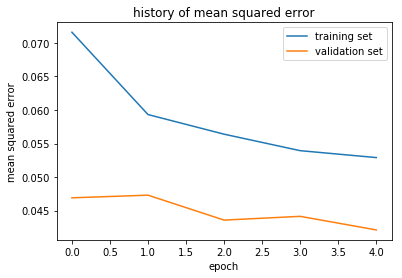

In [11]:
### Visualizing loss function for training/validation set

plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('history of mean squared error')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.savefig('history_loss.png')
plt.show()